<a href="https://colab.research.google.com/github/h344lee/RNN-Price-Prediction/blob/main/RNN_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version

Python 3.6.9


In [ ]:
import pandas as pd
import numpy as np
from numpy import dstack
import os
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU, Bidirectional
from keras.models import load_model
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
import tensorflow_probability as tfp
import requests
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tfd = tfp.distributions
tfk = tf.keras

# BTCUSD GOOGL AMZN 
stock = 'GOOGL'
start_date = '2015-05-01'
end_date = '2019-11-30'

stock_data = requests.get(
        f"https://financialmodelingprep.com/api/v3/historical-price-full/"+stock+"?from=" + start_date + "&to=" + end_date + "&apikey=46f04987aa206f82fb430cfc7087f737")

stock_data = stock_data.json()["historical"]
df = pd.DataFrame.from_dict(stock_data, orient='columns')[::-1]
stock_df = df[['date','open', 'high','low','close','volume']]

gold_data = requests.get(
        f"https://financialmodelingprep.com/api/v3/historical-price-full/GCUSD?from=" + start_date + "&to=" + end_date + "&apikey=46f04987aa206f82fb430cfc7087f737")


gold_data = gold_data.json()["historical"]
df = pd.DataFrame.from_dict(gold_data, orient='columns')[::-1]
gold_df = df[['date','open']]
gold_df.rename(columns={'open': 'gold'}, inplace=True)

mergeDF = pd.merge(stock_df, gold_df)

oil_data = requests.get(
        f"https://financialmodelingprep.com/api/v3/historical-price-full/CLUSD?from=" + start_date + "&to=" + end_date + "&apikey=46f04987aa206f82fb430cfc7087f737")


oil_data = oil_data.json()["historical"]
df = pd.DataFrame.from_dict(oil_data, orient='columns')[::-1]
oil_df = df[['date','open']]
oil_df.rename(columns={'open': 'oil'}, inplace=True)

mergeDF = pd.merge(mergeDF, oil_df)

euro_data = requests.get(
        f"https://financialmodelingprep.com/api/v3/historical-price-full/EURUSD?from=" + start_date + "&to=" + end_date + "&apikey=46f04987aa206f82fb430cfc7087f737")


euro_data = euro_data.json()["historical"]
df = pd.DataFrame.from_dict(euro_data, orient='columns')[::-1]
euro_df = df[['date','open']]
euro_df.rename(columns={'open': 'EURUSD'}, inplace=True)

mergeDF = pd.merge(mergeDF, euro_df)

jpy_data = requests.get(
        f"https://financialmodelingprep.com/api/v3/historical-price-full/JPYUSD?from=" + start_date + "&to=" + end_date + "&apikey=46f04987aa206f82fb430cfc7087f737")


jpy_data = jpy_data.json()["historical"]
df = pd.DataFrame.from_dict(jpy_data, orient='columns')[::-1]
jpy_df = df[['date','open']]
jpy_df.rename(columns={'open': 'JPYUSD'}, inplace=True)


mergeDF = pd.merge(mergeDF, jpy_df)

mergeDF.head(3)

scaler = MinMaxScaler()
scale_cols = ['open', 'high', 'low', 'close', 'volume', 'gold', 'oil', 'EURUSD', 'JPYUSD']
df_scaled = scaler.fit_transform(mergeDF[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols


TEST_SIZE = 200
# 학습은 과거부터 200일 이전의 데이터를 학습하게 되고, 
# TEST를 위해서 이후 200일의 데이터로 모델이 주가를 예측하도록 한 다음, 실제 데이터와 오차가 얼마나 있는지 확인
dataset = df_scaled
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]



In [ ]:

def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


def MLP(train, test, feature_cols, label_cols):

    train_feature = train[feature_cols]
    train_label = train[label_cols]

    test_feature = test[feature_cols]
    test_label = test[label_cols]

    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
    

    model = MLPRegressor(hidden_layer_sizes=[16, 128, 8], max_iter=8000, alpha=0.001, random_state=42)
    model.fit(x_train, y_train)

    # 예측

    train_pred = model.predict(train_feature)
    test_pred = model.predict(test_feature)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_pred, train_label))
    print('Train Score: %.3f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(test_pred, test_label))
    print('Test Score: %.3f RMSE' % (testScore))

    test_label = test_label.to_numpy()
    visualizer(test_label, test_pred, "MLP Prediction")

def SVR(train, test, feature_cols, label_cols):

    train_feature = train[feature_cols]
    train_label = train[label_cols]

    test_feature = test[feature_cols]
    test_label = test[label_cols]

    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
    
    from sklearn.svm import SVR
    model = SVR(kernel = 'linear')
    model.fit(x_train, y_train)

       # 예측

    train_pred = model.predict(train_feature)
    test_pred = model.predict(test_feature)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_pred, train_label))
    print('Train Score: %.3f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(test_pred, test_label))
    print('Test Score: %.3f RMSE' % (testScore))

    test_label = test_label.to_numpy()

    visualizer(test_label, test_pred, "SVR Prediction")


def bnn(dataset, feature_cols, label_cols):


    neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)



    # Define some hyperparameters.
    n_epochs = 50
    n_samples = dataset.shape[0]
    n_batches = 10
    batch_size = np.floor(n_samples/n_batches)
    buffer_size = n_samples
    # Define training and test data sizes.
    n_train = int(0.7*dataset.shape[0])
    # Define dataset instance.
    data = tf.data.Dataset.from_tensor_slices((dataset[feature_cols].values, dataset[label_cols].values))
    data = data.shuffle(n_samples, reshuffle_each_iteration=True)
    # Define train and test data instances.
    data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
    data_test = data.skip(n_train).batch(1).repeat(n_epochs)




    # Define prior for regularization.
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(label_cols), dtype=tf.float32), scale=1.0), reinterpreted_batch_ndims=1)
    # Define model instance.
    model = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=(len(feature_cols),), name="input"),
    tfk.layers.Dense(10, activation="relu", name="dense_1"),
    tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
    len(label_cols)), activation=None, name="distribution_weights"),
    tfp.layers.MultivariateNormalTriL(len(label_cols), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")], name="model")
    # Compile model.
    model.compile(optimizer="adam", loss=neg_log_likelihood)
    # Run training session.
    model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)

    tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")


    # Predict.
    samples = 100
    iterations = 1
    test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
    X_true, Y_true, Y_pred = np.empty(shape=(samples, len(feature_cols))), np.empty(shape=(samples, len(feature_cols))), np.empty(shape=(samples, len(feature_cols), iterations))
    for i in range(samples):
        features, labels = test_iterator.get_next()
        X_true[i,:] = features
        Y_true[i,:] = labels.numpy()
        for k in range(iterations):
            Y_pred[i,:,k] = model.predict(features)
            
    # Calculate mean and standard deviation.
    Y_pred_m = np.mean(Y_pred, axis=-1)
    Y_pred_s = np.std(Y_pred, axis=-1)

    print(Y_pred_m)
    print(Y_pred_s)

    plt.figure(figsize=(12, 9))
    plt.plot(Y_pred_m, label='mean')
    plt.plot(Y_pred_s, label='standard deviation')
    plt.legend()
    plt.show()




def gru(train, test, feature_cols, label_cols, window_size, units):

    train_feature = train[feature_cols]
    train_label = train[label_cols]

    # train dataset
    train_feature, train_label = make_dataset(train_feature, train_label, window_size)

    # train, validation set 생성
    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

    x_train.shape, x_valid.shape
    # ((6086, 20, 4), (1522, 20, 4))

    test_feature = test[feature_cols]
    test_label = test[label_cols]

    # test dataset (실제 예측 해볼 데이터)
    test_feature, test_label = make_dataset(test_feature, test_label, window_size)
    test_feature.shape, test_label.shape
    # ((180, 20, 4), (180, 1))

    model = Sequential()
    model.add(GRU(units,input_shape=(train_feature.shape[1], train_feature.shape[2]), return_sequences=False ) )
    model.add(Dropout(0.2))
    # model.add(GRU(units = 64,return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(GRU(units = 32))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    filename = os.path.join('./', 'gru.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    GRU_history = model.fit(x_train, y_train, 
                        epochs=200, 
                        batch_size=16,
                        validation_data=(x_valid, y_valid), 
                        callbacks=[early_stop, checkpoint])

    # weight 로딩
    model.load_weights(filename)

    # prediction
    train_pred = model.predict(train_feature)
    test_pred = model.predict(test_feature)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_pred, train_label))
    print('Train Score: %.3f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(test_pred, test_label))
    print('Test Score: %.3f RMSE' % (testScore))
    
    visualizer(test_label, test_pred, "GRU Prediction")


def bilstm(train, test, feature_cols, label_cols, window_size, units):


    train_feature = train[feature_cols]
    train_label = train[label_cols]

    # train dataset
    train_feature, train_label = make_dataset(train_feature, train_label, window_size)

    # train, validation set 생성
    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

    x_train.shape, x_valid.shape
    # ((6086, 20, 4), (1522, 20, 4))

    test_feature = test[feature_cols]
    test_label = test[label_cols]

    # test dataset (실제 예측 해볼 데이터)
    test_feature, test_label = make_dataset(test_feature, test_label, window_size)
    test_feature.shape, test_label.shape
    # ((180, 20, 4), (180, 1))


    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=False),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    # model.add(Dropout(0.2))
    # model.add(Bidirectional(LSTM(units = 24,return_sequences=True)))
    # model.add(Dropout(0.2))
    # model.add(Bidirectional(LSTM(units = 16)))

    model.add(Dense(1))

    #Compile model
    model.compile(loss='mse', optimizer='adam')
  
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    filename = os.path.join('./', 'bilstm.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    lstm_history = model.fit(x_train, y_train, 
                        epochs=200, 
                        batch_size=16,
                        validation_data=(x_valid, y_valid), 
                        callbacks=[early_stop, checkpoint])

    # weight 로딩
    model.load_weights(filename)

    # 예측

    train_pred = model.predict(train_feature)
    test_pred = model.predict(test_feature)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_pred, train_label))
    print('Train Score: %.3f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(test_pred, test_label))
    print('Test Score: %.3f RMSE' % (testScore))

    visualizer(test_label, test_pred, "B-LSTM Prediction")
    


def lstm(train, test, feature_cols, label_cols, window_size, units):

    train_feature = train[feature_cols]
    train_label = train[label_cols]

    # train dataset
    train_feature, train_label = make_dataset(train_feature, train_label, window_size)

    # train, validation set 생성
    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

    x_train.shape, x_valid.shape
    # ((6086, 20, 4), (1522, 20, 4))

    test_feature = test[feature_cols]
    test_label = test[label_cols]

    # test dataset (실제 예측 해볼 데이터)
    test_feature, test_label = make_dataset(test_feature, test_label, window_size)
    test_feature.shape, test_label.shape
    # ((180, 20, 4), (180, 1))

    model = Sequential()
    model.add(LSTM(units, 
                  input_shape=(train_feature.shape[1], train_feature.shape[2]), 
                  return_sequences=False)
              )
    # model.add(Dropout(0.2))
    # model.add(LSTM(64, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(32, return_sequences=False))


    model.add(Dense(1))


    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    filename = os.path.join('./', 'lstm.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    lstm_history = model.fit(x_train, y_train, 
                        epochs=200, 
                        batch_size=16,
                        validation_data=(x_valid, y_valid), 
                        callbacks=[early_stop, checkpoint])

    # weight 로딩
    model.load_weights(filename)

    # 예측
    train_pred = model.predict(train_feature)
    test_pred = model.predict(test_feature)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_pred, train_label))
    print('Train Score: %.3f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(test_pred, test_label))
    print('Test Score: %.3f RMSE' % (testScore))

    visualizer(test_label, test_pred, "LSTM Prediction")


# load models from file
def load_all_models():
    models = ['lstm', 'gru', 'bilstm']
    #models = ['bilstm', 'gru']


    all_models = []
    for model in models:
        filename = model + '.h5'
        model = load_model(filename)
        all_models.append(model)
    return all_models


# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(inputX):
    stackX = None
    models = load_all_models()
    for model in models:
      # make prediction
      yhat = model.predict(inputX, verbose=0)
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = dstack((stackX, yhat))


    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(inputX, inputy, window_size):


    # create dataset using ensemble
    stackedX = stacked_dataset(inputX)
    # fit standalone model
    model = KNeighborsRegressor(n_neighbors=3)
    model.fit(stackedX, inputy[window_size:])
    return model

# make a prediction with the stacked model
def stacked_prediction(inputX, inputy, window_size):

    test_feature, test_label = make_dataset(inputX, inputy, window_size)
    model = fit_stacked_model(test_feature, inputy, window_size)
    # create dataset using ensemble
    stackedX = stacked_dataset(test_feature)
    # make a prediction
    ensemble_pred = model.predict(stackedX)

    # calculate root mean squared error
    testScore = math.sqrt(mean_squared_error(ensemble_pred, test_label))
    print('Test Score: %.3f RMSE' % (testScore))

    visualizer(test_label, ensemble_pred, "Ensemble Prediction")



def visualizer(test_label, pred, title):
    fig, ax = plt.subplots()
    plt.title('Comparison Between Actual Price and ' + title +' Price')
    plt.ylabel('Price')
    plt.xlabel('Date')
    
    plt.plot(test_label, color='r', label='Actual Price')
    plt.plot(pred, color='b', label='Prediction Price')
    
    ax.grid(True)
    fig.tight_layout()
    plt.legend()
    plt.savefig(title + '.svg', format='svg')
    plt.show()

def run_all(train, test, feature_cols, label_cols, window_size, units):
    lstm(train, test, feature_cols, label_cols, window_size, units)
    gru(train, test, feature_cols, label_cols, window_size, units)
    bilstm(train, test, feature_cols, label_cols, window_size, units)
    stacked_prediction(test[feature_cols], test[label_cols], window_size)






Epoch 1/200
47/47 [==============================] - 2s 17ms/step - loss: 0.0469 - val_loss: 0.0015

Epoch 00001: val_loss improved from inf to 0.00154, saving model to ./lstm.h5
Epoch 2/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.4878e-04

Epoch 00002: val_loss improved from 0.00154 to 0.00095, saving model to ./lstm.h5
Epoch 3/200
47/47 [==============================] - 0s 4ms/step - loss: 8.9708e-04 - val_loss: 9.3871e-04

Epoch 00003: val_loss improved from 0.00095 to 0.00094, saving model to ./lstm.h5
Epoch 4/200
47/47 [==============================] - 0s 4ms/step - loss: 7.7844e-04 - val_loss: 8.9761e-04

Epoch 00004: val_loss improved from 0.00094 to 0.00090, saving model to ./lstm.h5
Epoch 5/200
47/47 [==============================] - 0s 4ms/step - loss: 8.5513e-04 - val_loss: 8.7816e-04

Epoch 00005: val_loss improved from 0.00090 to 0.00088, saving model to ./lstm.h5
Epoch 6/200
47/47 [==============================] - 0s 4ms/step 

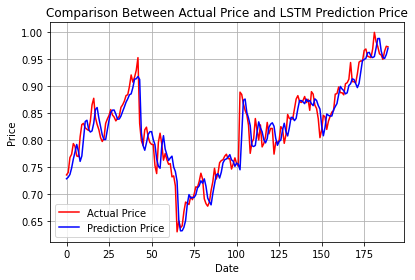

Epoch 1/200
47/47 [==============================] - 2s 15ms/step - loss: 0.0555 - val_loss: 0.0010

Epoch 00001: val_loss improved from inf to 0.00104, saving model to ./gru.h5
Epoch 2/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 8.4253e-04

Epoch 00002: val_loss improved from 0.00104 to 0.00084, saving model to ./gru.h5
Epoch 3/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0012

Epoch 00003: val_loss did not improve from 0.00084
Epoch 4/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 8.7559e-04

Epoch 00004: val_loss did not improve from 0.00084
Epoch 5/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.2183e-04

Epoch 00005: val_loss improved from 0.00084 to 0.00082, saving model to ./gru.h5
Epoch 6/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0012

Epoch 00006: val_loss did not improve from 0.0

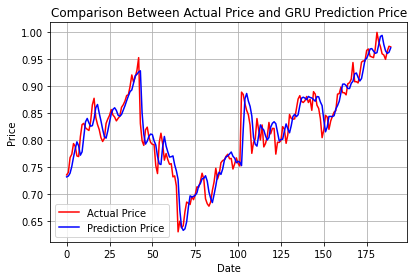

Epoch 1/200
47/47 [==============================] - 3s 19ms/step - loss: 0.0513 - val_loss: 0.0014

Epoch 00001: val_loss improved from inf to 0.00136, saving model to ./bilstm.h5
Epoch 2/200
47/47 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 9.2280e-04

Epoch 00002: val_loss improved from 0.00136 to 0.00092, saving model to ./bilstm.h5
Epoch 3/200
47/47 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 7.9730e-04

Epoch 00003: val_loss improved from 0.00092 to 0.00080, saving model to ./bilstm.h5
Epoch 4/200
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 7.7542e-04

Epoch 00004: val_loss improved from 0.00080 to 0.00078, saving model to ./bilstm.h5
Epoch 5/200
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 7.6082e-04

Epoch 00005: val_loss improved from 0.00078 to 0.00076, saving model to ./bilstm.h5
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - 

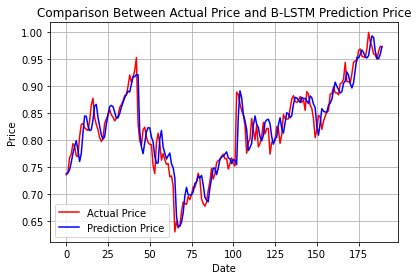

Test Score: 0.020 RMSE


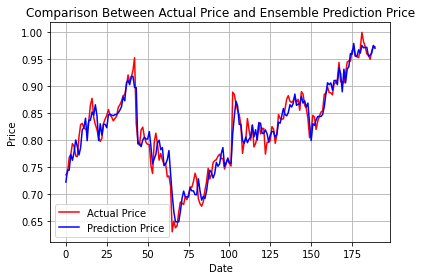

In [ ]:
stock_only = ['open', 'high', 'low', 'volume']
stock_external = ['open', 'high', 'low', 'volume', 'gold', 'oil']
stock_external_exchange = ['open', 'high', 'low', 'volume', 'gold', 'oil', 'EURUSD', 'JPYUSD']

feature_cols = stock_only
label_cols = ['close']

run_all(train, test, feature_cols, label_cols, 10, 256)   # window size and units


#lstm(train, test, feature_cols, label_cols)
#SVR(train, test, feature_cols, label_cols)
#MLP(train, test, feature_cols, label_cols)
#gru(train, test, feature_cols, label_cols)
#bnn(dataset, feature_cols, label_cols)
#bilstm(train, test, feature_cols, label_cols)